In [10]:
import numpy as np
from sklearn import svm
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, load_boston, load_iris, load_digits
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/chandola/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X = np.array([[0, 0], [0,1],[1,1],[1,0],[4, 4],[3,3],[4,3],[3,4]])
y = np.array([-1, -1,-1,-1,1,1,1,1])
 

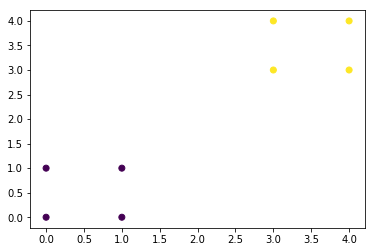

In [3]:
plt.scatter(X[:,0],X[:,1],c=y)

In [4]:
clf = svm.SVC()
clf.fit(X, y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

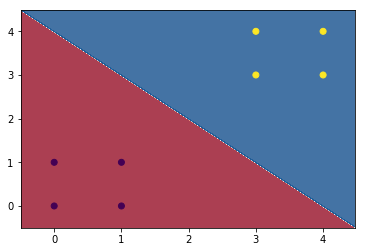

In [60]:
#plt boundary
h = 0.02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(X[:,0],X[:,1],c=y)

In [62]:
clf.dual_coef_ # these are the alphas

array([[-0.25,  0.25]])

In [61]:
clf.support_vectors_

array([[ 1.,  1.],
       [ 3.,  3.]])

### Computing w
$w = \sum_{sv} \alpha_n y_n {\bf x}_n$

In [63]:
-0.25*clf.support_vectors_[0]*1 + 0.25*clf.support_vectors_[1]*(-1)

array([-1., -1.])

### Computing b
${\bf w}^\top {\bf x} + b = 1$, if class is +1 and ${\bf x}$ is on the positive margin.

## SVM Learning in non-separable case

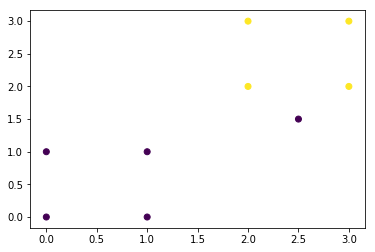

In [69]:
X = np.array([[0, 0], [0,1],[1,1],[1,0],[2.5,1.5],[2, 2],[3,3],[2,3],[3,2]])
y = np.array([-1, -1,-1,-1,-1,1,1,1,1])
plt.scatter(X[:,0],X[:,1],c=y)

In [81]:
clf = svm.SVC(kernel='linear',C=1)
clf.fit(X,y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

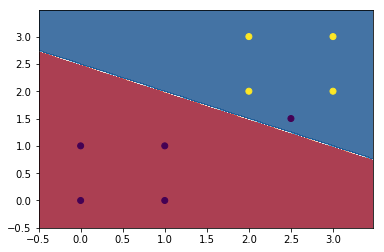

In [82]:
#plt boundary
h = 0.02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(X[:,0],X[:,1],c=y)

### Non -linear SVM

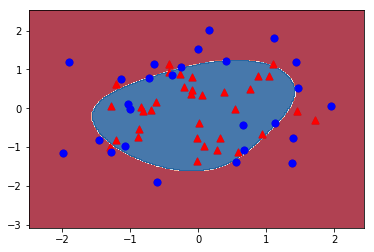

In [23]:
h = .02  # step size in the mesh


ds = make_circles(noise=0.3, factor=0.6, random_state=1)

# preprocess dataset, split into training and test part
X, y = ds
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
# Plot the training points
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='r',marker='^',s=48)
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='b',marker='o',s=48)


clf = svm.SVC(kernel='rbf',C=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot also the training points
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='r',marker='^',s=48)
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='b',marker='o',s=48)    

plt.show()

In [28]:
X.shape

(100, 2)

In [27]:
clf.support_vectors_.shape

(48, 2)

In [29]:
clf.dual_coef_

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -0.05417219, -1.        , -0.6009209 , -0.16663727, -0.3609557 ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
         1.        ,  1.        ,  1.        ,  0.84302407,  0.97685804,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  0.86342075,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  0.49938318]])